<a href="https://colab.research.google.com/github/edrian-liao/harvestnet/blob/main/notebooks/HarvestNet2_Train_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Packages

Conda was being funky with the python sys.executable, so decided to just import required packages using pip.

In [1]:
!pip install wandb -qU
!pip install torchmetrics -qU
!pip install accelerate -qU
!pip install torchsampler

In [2]:
import os
import time
import torch
from torch.utils.data import DataLoader
import torchvision
import wandb
import numpy as np
from torchmetrics import Accuracy, F1Score, AUROC, Precision, Recall
from accelerate import Accelerator
from collections import defaultdict
import cv2

In [4]:
from tools.dataset import SkysatLabelled
from tools.config import Config_Resnet

Login to wandb. might need to make an account.
After creating account, you will get an API passkey, paste back into colab.

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load Dataset

In [5]:
# -----------------
# CONFIG
# -----------------

config = Config_Resnet()


# Seed
torch.manual_seed(config.seed)
np.random.seed(config.seed)


accelerator = Accelerator(
    log_with="wandb",
    mixed_precision=config.mixed_precision,
)
device = accelerator.device

# Log on each process the small summary:
if accelerator.is_main_process:
    print(f"Training/evaluation parameters:")
    print(config.__dict__)

accelerator.init_trackers(
    config.wandb_project,
    config=config,
    init_kwargs={
        "wandb": {
            "group": config.wandb_group,
            "reinit": True,
            "dir": os.path.join(config.working_dir),
        }
    },
)

LOGGING = True
if LOGGING:
    accelerator.init_trackers(
        config.wandb_project,
        config=config,
        init_kwargs={
            "wandb": {
                "group": config.wandb_group,
                "reinit": True,
                "dir": os.path.join(config.working_dir),
            }
        },
    )


# -----------------
# DATASET
# -----------------
if accelerator.is_main_process:
    print("Loading datasets")
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224, 224)),
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.412, 0.368, 0.326], std=[0.110, 0.097, 0.098]
        ),  # our dataset vals
    ]
)
augment = torchvision.transforms.Compose(
[
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.412, 0.368, 0.326], std=[0.110, 0.097, 0.098]
    ),  # our dataset vals
]
)

Training/evaluation parameters:
{'working_dir': 'harvest-piles', 'dataset_path': 'dataset', 'wandb_project': 'harvest-piles', 'wandb_group': 'resnet50', 'seed': 2023, 'scheduler': 'one_cycle_lr', 'lr': 0.001, 'optimizer': 'madgrad', 'mixed_precision': 'fp16', 'num_train_epochs': 30, 'batch_size': 32}


wandb: Currently logged in as: edrianpaul-liao (ece661). Use `wandb login --relogin` to force relogin
wandb: WARNING Path harvest-piles/wandb/ wasn't writable, using system temp directory.


Loading datasets


Mount google drive in order to load big skysat_images folder. Regular zipped upload did not work. Make sure you complete the following:
1. upload to your google drive a zipped version of skysat_images. make sure to name is skysat_images.zip
2. run the following code
3. after successfully unzipping skysat_images, make sure to move it to Dataset folder

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!unzip -o "/content/drive/MyDrive/Academics/Spring 2024/ECE 661/Final Project/Dataset.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/skysat_images/1572.tif  
  inflating: /content/dataset/skysat_images/157200.tif  
  inflating: /content/dataset/skysat_images/157201.tif  
  inflating: /content/dataset/skysat_images/157202.tif  
  inflating: /content/dataset/skysat_images/157203.tif  
  inflating: /content/dataset/skysat_images/157204.tif  
  inflating: /content/dataset/skysat_images/157205.tif  
  inflating: /content/dataset/skysat_images/157206.tif  
  inflating: /content/dataset/skysat_images/157207.tif  
  inflating: /content/dataset/skysat_images/157208.tif  
  inflating: /content/dataset/skysat_images/157209.tif  
  inflating: /content/dataset/skysat_images/157210.tif  
  inflating: /content/dataset/skysat_images/157211.tif  
  inflating: /content/dataset/skysat_images/157212.tif  
  inflating: /content/dataset/skysat_images/157213.tif  
  inflating: /content/dataset/skysat_images/157214.tif  
  inflating: /content/dataset/skysat_im

In [6]:
!unzip -o "/content/drive/MyDrive/Academics/Spring 2024/ECE 661/Final Project/Patch_Dataset.zip" -d "/content/dataset/patch_images"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/patch_images/50456_1.tif  
  inflating: /content/dataset/patch_images/50456_2.tif  
  inflating: /content/dataset/patch_images/50456_3.tif  
  inflating: /content/dataset/patch_images/50456_4.tif  
  inflating: /content/dataset/patch_images/5048_1.tif  
  inflating: /content/dataset/patch_images/5048_2.tif  
  inflating: /content/dataset/patch_images/5048_3.tif  
  inflating: /content/dataset/patch_images/5048_4.tif  
  inflating: /content/dataset/patch_images/50497_1.tif  
  inflating: /content/dataset/patch_images/50497_2.tif  
  inflating: /content/dataset/patch_images/50497_3.tif  
  inflating: /content/dataset/patch_images/50497_4.tif  
  inflating: /content/dataset/patch_images/50498_1.tif  
  inflating: /content/dataset/patch_images/50498_2.tif  
  inflating: /content/dataset/patch_images/50498_3.tif  
  inflating: /content/dataset/patch_images/50498_4.tif  
  inflating: /content/dataset/patch_image

NOTE: Move the unzipped sky_sat images into Dataset folder before continuing

# Preprocess CSVs to Remove Broken Images

Train Dataset

In [6]:
import pandas as pd
import os

IMAGE_DIR_TRAIN = "dataset/patch_images"
IMAGE_DIR_TEST = "dataset/skysat_images"
TRAIN_FILE = "dataset/new_train.csv"
TEST_FILE = "dataset/test.csv"

df = pd.read_csv(TRAIN_FILE, usecols=["filename"])
df.reset_index(inplace=True, drop=True)
examples = df["filename"]
print(examples)

0        16965_1.tif
1        16965_2.tif
2        16965_3.tif
3        16965_4.tif
4        22851_1.tif
            ...     
22119     4463_4.tif
22120    17192_1.tif
22121    17192_2.tif
22122    17192_3.tif
22123    17192_4.tif
Name: filename, Length: 22124, dtype: object


In [7]:
# Get broken images
broken_images = []
for index in range(len(examples)):
    try:
        path = os.path.join(IMAGE_DIR_TRAIN, examples[index])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except:
        print(examples[index])
        broken_images.append(examples[index])

In [8]:
print(len(broken_images))

0


Remove Them

In [7]:
# get the original train and test csv
train = pd.read_csv(TRAIN_FILE)
train = train.iloc[:, 1:]

test = pd.read_csv(TEST_FILE)
test = test.iloc[:, 1:]

print(train.shape)
print(test.shape)

(22124, 14)
(1383, 13)


In [8]:
# filter the broken images from train and test csv
train_filtered = train[~train['filename'].isin(broken_images)]
train_filtered.reset_index(inplace=True)

test_filtered = test[~test['filename'].isin(broken_images)]
test_filtered.reset_index(inplace=True)

print(train_filtered.shape)
print(test_filtered.shape)

NameError: name 'broken_images' is not defined

In [9]:
for index, row in train_filtered.iterrows():
    if int(row["filename"][:-4]) != index:
        print (index)
        break

for index, row in test_filtered.iterrows():
    if int(row["filename"][:-4]) != index:
        print (index)
        break



# drop level_0 and index columns
train_filtered.drop(["index"], axis=1, inplace=True)
test_filtered.drop(["index"], axis=1, inplace=True)

print(train_filtered.shape)
print(test_filtered.shape)

NameError: name 'train_filtered' is not defined

In [13]:
# replace the train and test csvs with the filtered versions
train_filtered.to_csv("dataset/new_train.csv")
test_filtered.to_csv("dataset/test.csv")


In [10]:
# LOAD DATASETS
ROOT_PATH = "dataset"
train_dataset = SkysatLabelled(
    os.path.join(config.dataset_path, "new_train.csv"),
    os.path.join(config.dataset_path, "patch_images"),
    augment
)

test_dataset = SkysatLabelled(
    os.path.join(config.dataset_path, "test.csv"),
    os.path.join(config.dataset_path, "skysat_images"),
    transform
)

In [11]:
from torchsampler import ImbalancedDatasetSampler

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    num_workers=2,
    pin_memory=True,
    sampler=ImbalancedDatasetSampler(train_dataset)
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)


Check the content of both datasets to confirm we are looking at the correct data.

In [12]:
# check how many images are in train_dataset
print(len(train_dataset))
print(len(test_dataset))

22124
1383


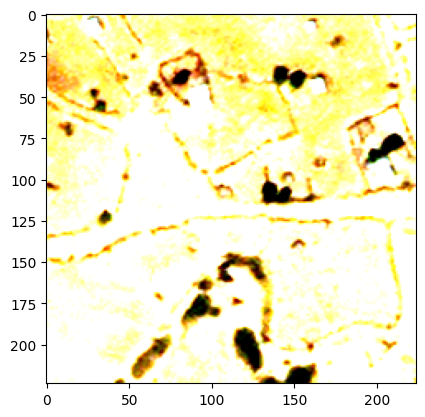

In [13]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[0][0].permute(1,2,0))

# Train Dataset

At this point, hopefully the model can be trained.

In [14]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Create the Focal Loss criterion
criterion = FocalLoss(alpha=1, gamma=2)
# criterion = torch.nn.BCELoss()

In [15]:
# -----------------
# MODEL
# -----------------
if accelerator.is_main_process:
    print("Loading model")

model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2


class ResNet50(torch.nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet50 = torchvision.models.resnet50(weights=model_weights)
        num_features = self.resnet50.fc.out_features
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(num_features, num_classes),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.resnet50(x)
        return self.fc(logits)


out_classes = 1
model = ResNet50(out_classes)

# -----------------
# OPTIMIZER, SCHEDULER
# -----------------
# criterion = torch.nn.BCELoss()

accuracy = Accuracy(task="binary")
f1_score = F1Score(task="binary")
auroc = AUROC(task="binary")
precision = Precision(task="binary")
recall = Recall(task="binary")

FOUND_LR = config.lr  # For OneCycleLR
# FOUND_LR = 0.001 # For ExponentialLR


params = [
    {"params": model.resnet50.conv1.parameters(), "lr": FOUND_LR / 10},
    {"params": model.resnet50.bn1.parameters(), "lr": FOUND_LR / 10},
    {"params": model.resnet50.layer1.parameters(), "lr": FOUND_LR / 8},
    {"params": model.resnet50.layer2.parameters(), "lr": FOUND_LR / 6},
    {"params": model.resnet50.layer3.parameters(), "lr": FOUND_LR / 4},
    {"params": model.resnet50.layer4.parameters(), "lr": FOUND_LR / 2},
    {"params": model.resnet50.fc.parameters()},
]
if config.optimizer == "adam":
    optimizer = torch.optim.Adam(params, lr=config.lr)
elif config.optimizer == "madgrad":
    from tools.madgrad import MADGRAD

    optimizer = MADGRAD(params, lr=config.lr)

STEPS_PER_EPOCH = len(train_dataloader)
TOTAL_STEPS = config.num_train_epochs * STEPS_PER_EPOCH
MAX_LRS = [p["lr"] for p in optimizer.param_groups]

if config.scheduler == "one_cycle_lr":
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=MAX_LRS, total_steps=TOTAL_STEPS
    )

# -----------------
# ACCELERATOR
# -----------------
model, optimizer, train_dataloader, test_dataloader, scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, test_dataloader, scheduler
)
accuracy, f1_score, auroc, precision, recall = accelerator.prepare(
    accuracy, f1_score, auroc, precision, recall
)

# -----------------
# TRAIN
# -----------------
if accelerator.is_main_process:
    print("Begin train")


def train(model, iterator, optimizer, criterion, scheduler):
    epoch_loss = 0
    sum_metrics = defaultdict(float)

    model.train()
    for x, y, _ in iterator:
        optimizer.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)
        evals = {
            "acc": accuracy(pred, y),
            "f1": f1_score(pred, y),
            "auroc": auroc(pred, y),
            "precision": precision(pred, y),
            "recall": recall(pred, y),
        }
        for k, v in evals.items():
            sum_metrics[k] += v

        accelerator.backward(loss)
        optimizer.step()
        if config.scheduler == "one_cycle_lr":
            scheduler.step()

        epoch_loss += loss.item()

    if config.scheduler != "one_cycle_lr":
        scheduler.step()

    epoch_loss /= len(iterator)
    avg_metrics = {k: v / len(iterator) for k, v in sum_metrics.items()}
    print("Train: ", avg_metrics)

    return epoch_loss, avg_metrics


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    sum_metrics = defaultdict(float)

    model.eval()

    with torch.no_grad():
        for x, y, _ in iterator:
            pred = model(x)
            loss = criterion(pred, y)
            evals = {
                "acc": accuracy(pred, y),
                "f1": f1_score(pred, y),
                "auroc": auroc(pred, y),
                "precision": precision(pred, y),
                "recall": recall(pred, y),
            }
            for k, v in evals.items():
                sum_metrics[k] += v

            epoch_loss += loss.item()

    epoch_loss /= len(iterator)
    avg_metrics = {k: v / len(iterator) for k, v in sum_metrics.items()}
    print("Test: ", avg_metrics)

    return epoch_loss, avg_metrics


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


best_val = 0

if LOGGING:
    print("Batch size:", config.batch_size)
    print("Batches per epoch:", len(train_dataloader))
for epoch in range(config.num_train_epochs):
    start_time = time.time()

    train_loss, train_metrics = train(
        model, train_dataloader, optimizer, criterion, scheduler
    )
    valid_loss, val_metrics = evaluate(model, test_dataloader, criterion)
    if LOGGING:
        wandb.log({"train.loss": train_loss}, commit=False)
        wandb.log({"train": train_metrics}, commit=False)
        wandb.log({"val.loss": valid_loss}, commit=False)
        wandb.log({"val": val_metrics}, commit=False)

    if val_metrics["acc"] > best_val:
        best_val = val_metrics["acc"]
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save(
            model.state_dict(), "Results/best_resnet_augment_new_data_upsampled.pt"
        )

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if accelerator.is_main_process:
        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(
            f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_metrics['acc'] * 100:6.2f}%"
        )
        print(
            f"\tValid Loss: {valid_loss:.3f} | Valid Acc: {val_metrics['acc'] * 100:6.2f}%"
        )

    if LOGGING:
        wandb.log({"epoch": epoch}, commit=True)

Loading model
Begin train
Batch size: 32
Batches per epoch: 692


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train:  {'acc': tensor(0.7317, device='cuda:0'), 'f1': tensor(0.6197, device='cuda:0'), 'auroc': tensor(0.8774, device='cuda:0'), 'precision': tensor(0.8369, device='cuda:0'), 'recall': tensor(0.5133, device='cuda:0')}
Test:  {'acc': tensor(0.6999, device='cuda:0'), 'f1': tensor(0.4953, device='cuda:0'), 'auroc': tensor(0.7809, device='cuda:0'), 'precision': tensor(0.8905, device='cuda:0'), 'recall': tensor(0.3532, device='cuda:0')}
Epoch: 01 | Epoch Time: 4m 20s
	Train Loss: 0.144 | Train Acc:  73.17%
	Valid Loss: 0.157 | Valid Acc:  69.99%
Train:  {'acc': tensor(0.8257, device='cuda:0'), 'f1': tensor(0.7986, device='cuda:0'), 'auroc': tensor(0.9373, device='cuda:0'), 'precision': tensor(0.9348, device='cuda:0'), 'recall': tensor(0.7081, device='cuda:0')}
Test:  {'acc': tensor(0.7531, device='cuda:0'), 'f1': tensor(0.6212, device='cuda:0'), 'auroc': tensor(0.8344, device='cuda:0'), 'precision': tensor(0.8938, device='cuda:0'), 'recall': tensor(0.4950, device='cuda:0')}
Epoch: 02 | Epo

In [16]:
# check best val
print(best_val)

tensor(0.7748, device='cuda:0')


Text(0.5, 1.0, 'HarvestNet 2.0 ResNet-50 Performance')

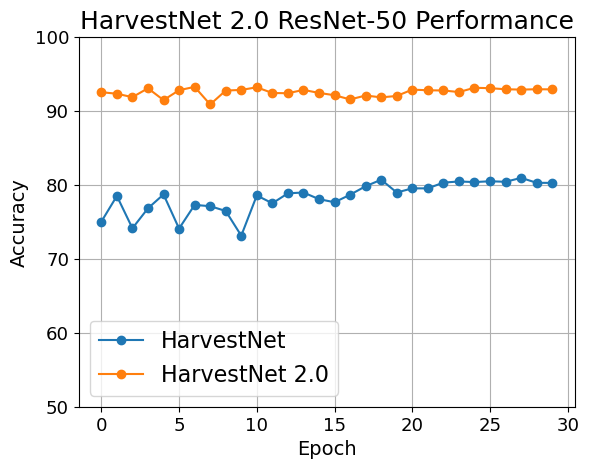

In [ ]:
import matplotlib.pyplot as plt
# train_accs = [90.29, 92.12, 92.22, 92.37, 92.29, 92.44, 92.51, 92.53, 92.91, 93.28, 93.58, 93.8, 94.42, 94.68, 95.1, 95.53, 96.24, 96.62, 97.35, 97.67, 98.18, 98.78, 98.96, 99.39, 99.53, 99.74, 99.78, 99.79, 99.88, 99.94]
val_accs = [92.55, 92.34, 91.88, 93.08, 91.48, 92.82, 93.27, 90.89, 92.77, 92.86, 93.21, 92.44, 92.41, 92.86, 92.45, 92.14, 91.57, 92.1, 91.85, 92.04, 92.9, 92.81, 92.78, 92.57, 93.15, 93.09, 92.95, 92.9, 92.95, 92.93]
val_accs_base = [
    75.03, 78.51, 74.14, 76.84, 78.72,
    74.10, 77.30, 77.13, 76.48, 73.14,
    78.58, 77.52, 78.87, 78.98, 78.08,
    77.66, 78.68, 79.83, 80.71, 78.98,
    79.54, 79.54, 80.32, 80.47, 80.39,
    80.50, 80.43, 80.96, 80.29, 80.28
]
plt.plot(val_accs_base, label='HarvestNet', marker='o')
plt.plot(val_accs, label='HarvestNet 2.0', marker='o')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(50,100)
plt.legend(fontsize=16)
plt.grid(True)

# Increase font size of ticks
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("HarvestNet 2.0 ResNet-50 Performance", fontsize=18)
